In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

In [3]:
sys.path.append("/home/jellouli/dataset-distillation/external/DeepInversion/cifar10")
sys.path.append("/home/jellouli/dataset-distillation")

In [4]:
TEACHER_WEIGHTS_PATH = "/home/jellouli/dataset-distillation/model_weights/final_state_resnet.tar"

In [5]:
CIFAR10_PATH = '/mlodata1/jellouli'

In [6]:
import torch
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torch.nn as nn
from resnet_cifar import ResNet18
import collections
import random
import tqdm
import numpy as np
import cifar10_helpers as H
from trainer import ResnetTrainer
from deep_inversion import DeepInversion, RandomSampler, StudentTrainer, TensorDatasetWrapper

Please install apex from https://www.github.com/nvidia/apex to run this example.
will attempt to run without it


In [7]:
test_set = H.load_cifar10_test(root=CIFAR10_PATH)

In [8]:
model = ResNet18()

In [9]:
model.load_state_dict(torch.load(TEACHER_WEIGHTS_PATH)['best_model'])

<All keys matched successfully>

r_feature_weight=10 --di_lr=0.1 --exp_descr="paper_parameters_better" --di_var_scale=0.001 --di_l2_scale=0.0

In [10]:
bs = 256
lr = 0.1
l2_scale = 0.0
var_scale = 1e-3
batch_size = 250
bn_scale = 10

In [11]:
deep_i = DeepInversion(teacher_net=model,
                      input_shape=(32,32),
                      batch_size=batch_size, 
                      student_net=ResNet18(),
                      class_sampler= RandomSampler(batch_size),
                      epochs = 2000,
                      input_jitter= True,
                      l2_scale= l2_scale,
                      var_scale= var_scale,
                       comp_scale=0.0,
                      bn_scale= bn_scale, 
                      optimizer_class = torch.optim.Adam,
                      optimizer_kwargs= {"lr":lr}
                      )

In [12]:
gen = iter(deep_i)

In [13]:
batch, targets = next(gen)

100%|██████████| 2000/2000 [07:28<00:00,  4.46it/s]


In [ ]:
tqdm

In [14]:
10 * 250 // 60

41

In [17]:
torch.save(batch, '../data/batch.tar')
torch.save(targets, '../data/targets.tar')

# Generated images

In [12]:
batch = torch.load('../data/batch.tar')
targets = torch.load('../data/targets.tar')

In [13]:
def get_images_for_class(images,targets, class_, num_images=5):
    return images[np.argwhere(targets.cpu().numpy() == class_)][:num_images].squeeze(1)

In [14]:
def visualize_class_images(images,targets, class_, num_images=5):
    fig, axs = plt.subplots(ncols=num_images, figsize=(10,10), sharex=True, sharey=True)
    images = get_images_for_class(images,targets, class_, num_images)
    for i in range(num_images):
        axs[i].imshow(H.prepare_to_visualize(images[i]))
    axs[num_images // 2].text(s=H.class_to_name[int(class_)], x=16, y=-3, fontsize= 15)
    return fig

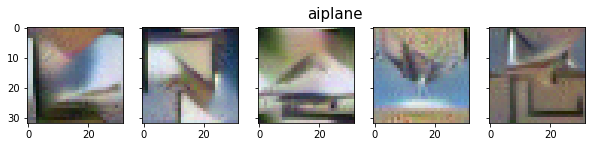

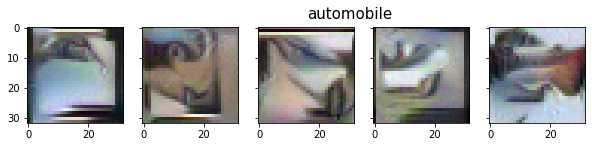

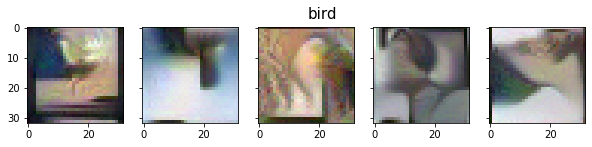

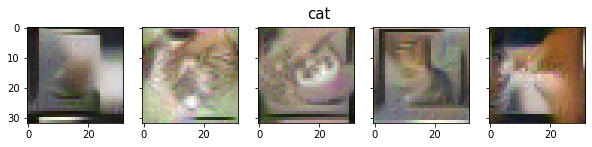

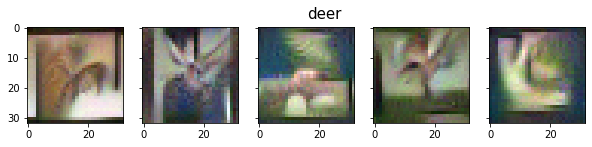

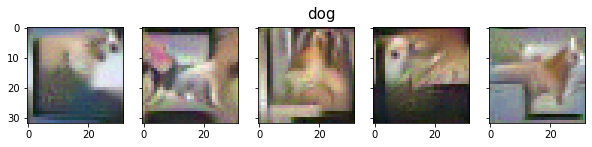

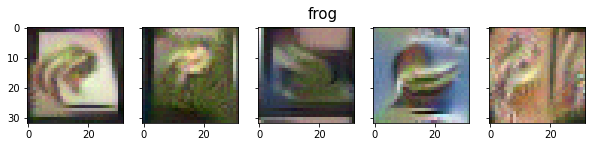

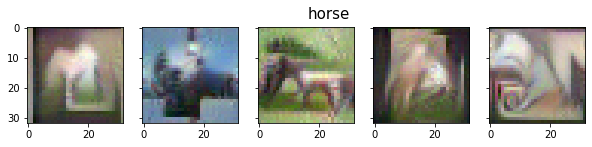

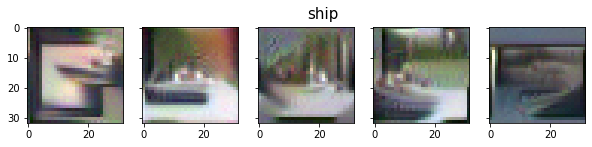

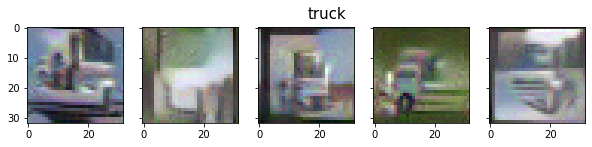

In [15]:
for i in range(10):
    visualize_class_images(batch, targets, i).show()

# Student Training


In [18]:
STUDENT_PATH = "../model_weights/final_state_student_resnet18.tar"
BASELINE_PATH  = "../model_weights/final_state_baseline.tar"

In [19]:
student_state = torch.load(STUDENT_PATH)
baseline_state = torch.load(BASELINE_PATH)

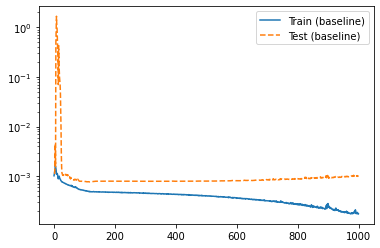

In [29]:
# plt.plot(student_state['train_losses'][:1000], label= 'Train (student)')
# plt.plot(student_state['test_losses'][:1000],linestyle='--', label="Test (student)")
plt.plot(baseline_state['train_losses'], label= 'Train (baseline)')
plt.plot(baseline_state['test_losses'],linestyle='--', label="Test (baseline)")

plt.yscale('log')
plt.legend()
plt.show()

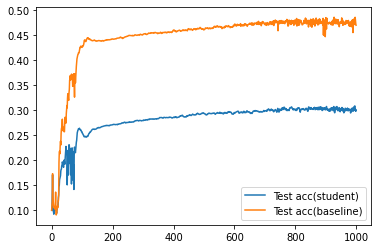

In [25]:
plt.plot(student_state['test_accs'][:1000], label= 'Test acc(student)')
plt.plot(baseline_state['test_accs'], label= 'Test acc(baseline)')
plt.legend()

In [27]:
print(f"Student best accuracy : {student_state['best_acc']}")
print(f"Baseline best accuracy : {baseline_state['best_acc']}")

Student best accuracy : 0.3114999830722809
Baseline best accuracy : 0.4861999750137329
